### **1. Bibliotecas**

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
import json
import numpy as np
import pandas as pd
from scipy import stats
from joblib import dump, load
from openai import OpenAI, AsyncOpenAI
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
client_async = AsyncOpenAI(api_key=os.getenv("OPENAI_API_KEY"))
import nest_asyncio  # noqa: E402
import asyncio  # noqa: E402
nest_asyncio.apply()
from tqdm.notebook import tqdm  # noqa: E402
tqdm.pandas()
from warnings import filterwarnings  # noqa: E402
filterwarnings('ignore')

#### **1.1 Funções**

In [2]:
# funcao para rotular um unico post
def gpt_label(text):
    try:
        response = client.chat.completions.create(
            # model="gpt-3.5-turbo",
            # model="gpt-4o",
            model="gpt-4o-mini",
            max_tokens=3,
            store=True,
            messages=[
                {
                    "role": "user",
                    "content": f"You are a data scientist who labels texts regarding sentiment with one of the options [1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ], with 1 being very negative sentiment and up to 7 being very positive sentiment. Answer only one number and label the following text: {text}",
                },
            ],
        )
        return response.choices[0].message
    except Exception as e:
        print(f'Erro ao rotular: {str(e)}')
        return 0

# funcao para rotular um unico post de forma assíncrona
async def gpt_label_async(text):
    try:
        response = await client_async.chat.completions.create(
            # model="gpt-3.5-turbo",
            # model="gpt-4o",
            model="gpt-4o-mini",
            max_tokens=3,
            store=True,
            messages=[
                {
                    "role": "user",
                    "content": f"You are a data scientist who labels texts regarding sentiment with one of the options [1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ], with 1 being very negative sentiment and up to 7 being very positive sentiment. Answer only one number and label the following text: {text}",
                },
            ],
        )
        return response.choices[0].message
    except Exception as e:
        print(f'Erro ao rotular: {str(e)}')
        return 0

# funcao para preparar aquivo jsonl para o batch
def create_jsonl(idx, prompt, text):
    prompts.append( # type: ignore
        {
            "custom_id": f"request-{idx}",
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": "gpt-4o-mini",
                "messages": [
                    {
                        "role": "user",
                        "content": prompt + str(text),
                    },
                ],
                "max_tokens": 3,
            },
        }
    )

# funcao para criar o batch na api
def create_batch(intervalo, arquivo, resultado, prompt, df):
    for idx, text in zip(intervalo,df['text'][intervalo]):
        create_jsonl(idx, prompt, text)

    # salvando arquivo jsonl com os prompts
    with open(arquivo, "w", encoding="utf-8") as file:
        for entry in prompts: # type: ignore
            file.write(json.dumps(entry) + "\n")

    # enviando arquivo jsonl para API
    batch_input_file = client.files.create(file=open(arquivo, "rb"), purpose="batch")

    # criando o lote do arquivo jsonl
    batch = client.batches.create(
        input_file_id=batch_input_file.id,
        endpoint="/v1/chat/completions",
        completion_window="24h",
        metadata={"description": f"gpt label dataset {arquivo}"},
    )

    dump(batch.to_dict(), "data/batch.z")
    dump(resultado, 'data/resultado.z')
    display(batch.to_dict())

# funcao para pegar rotulos do resultado
def get_labels(caminho_arquivo):        
    dados = []
    with open(caminho_arquivo, "r", encoding="utf-8") as file:
        for linha in file:
            dados.append(json.loads(linha))

    rotulos = []
    for i in range(len(dados)):
        try:
            rotulos.append(float(dados[i]["response"]["body"]["choices"][0]["message"]["content"]))           
        except ValueError:
            rotulos.append(4.0)

    return rotulos

def get_binary_labels(caminho_arquivo):        
    dados = []
    with open(caminho_arquivo, "r", encoding="utf-8") as file:
        for linha in file:
            dados.append(json.loads(linha))

    rotulos = []
    for i in range(len(dados)):
        try:
            rotulos.append(float(dados[i]["response"]["body"]["choices"][0]["message"]["content"]))           
        except ValueError:
            rotulos.append(0.0)

    return rotulos

# funcao para calcular a diferenca percentual entre os rotulos do gpt e os rotulos do dataframe
def diferenca_percentual(df_labels, gpt_labels):
    for i in range(len(df_labels)):
        percentual = np.abs((gpt_labels[i] - df_labels[i]) / df_labels[i]) * 100
        if percentual <= 25:
            gpt_labels[i] = df_labels[i]

    return gpt_labels

# pegar resultados do batch
def get_results(batch):
    resultado = load("data/resultado.z")
    output_file_id = client.batches.retrieve(batch["id"]).to_dict()["output_file_id"]
    file_response = client.files.content(output_file_id)
    file_response.write_to_file(resultado)

---
### **2. Dataset**

In [21]:
url = os.getenv("URL_DATASET")
df = pd.read_excel(url)
df.head(3)

,Text,Text_PT,Opinion(1/0),Question(1/0),Answer(1/0),Sentiment(1-7),Confusion(1-7),Urgency(1-7),CourseType,forum_post_id,course_display_name,forum_uid,created_at,post_type,anonymous,anonymous_to_peers,up_count,comment_thread_id,reads
0,Interesting! How often we say those things to ...,Interessante! Quantas vezes dizemos essas cois...,1,0,0,6.5,2.0,1.5,Education,5225177f2c501f0a00000015,Education/EDUC115N/How_to_Learn_Math,30CADB93E6DE4711193D7BD05F2AE95C,2013-09-02 22:55:59,Comment,0.0,0.0,0.0,5221a8262cfae31200000001,41.0
1,"What is \Algebra as a Math Game\"" or are you j...",O que é \ Álgebra como um jogo de matemática \...,0,1,0,4.0,5.0,3.5,Education,5207d0e9935dfc0e0000005e,Education/EDUC115N/How_to_Learn_Math,37D8FAEE7D0B94B6CFC57D98FD3D0BA5,2013-08-11 17:59:05,Comment,0.0,0.0,0.0,520663839df35b0a00000043,55.0
2,I like the idea of my kids principal who says ...,Gosto da ideia do diretor dos meus filhos que ...,1,0,0,5.5,3.0,2.5,Education,52052c82d01fec0a00000071,Education/EDUC115N/How_to_Learn_Math,CC11480215042B3EB6E5905EAB13B733,2013-08-09 17:53:06,Comment,0.0,0.0,0.0,51e59415e339d716000001a6,25.0


In [22]:
# nome das colunas em minusculo
df.columns = df.columns.str.lower()

# colunas binárias
df.insert(5, column='sentiment(1/0)', value=df["sentiment(1-7)"].apply(lambda x: 0 if x < 4 else 1))
df.insert(7, column='confusion(1/0)', value=df["confusion(1-7)"].apply(lambda x: 0 if x < 4 else 1))
df.insert(9, column='urgency(1/0)', value=df["urgency(1-7)"].apply(lambda x: 0 if x < 4 else 1))
df.head(2)

,text,text_pt,opinion(1/0),question(1/0),answer(1/0),sentiment(1/0),sentiment(1-7),confusion(1/0),confusion(1-7),urgency(1/0),...,forum_post_id,course_display_name,forum_uid,created_at,post_type,anonymous,anonymous_to_peers,up_count,comment_thread_id,reads
0,Interesting! How often we say those things to ...,Interessante! Quantas vezes dizemos essas cois...,1,0,0,1,6.5,0,2.0,0,...,5225177f2c501f0a00000015,Education/EDUC115N/How_to_Learn_Math,30CADB93E6DE4711193D7BD05F2AE95C,2013-09-02 22:55:59,Comment,0.0,0.0,0.0,5221a8262cfae31200000001,41.0
1,"What is \Algebra as a Math Game\"" or are you j...",O que é \ Álgebra como um jogo de matemática \...,0,1,0,1,4.0,1,5.0,0,...,5207d0e9935dfc0e0000005e,Education/EDUC115N/How_to_Learn_Math,37D8FAEE7D0B94B6CFC57D98FD3D0BA5,2013-08-11 17:59:05,Comment,0.0,0.0,0.0,520663839df35b0a00000043,55.0


In [25]:
dump(df, "data/df_stanford.z")

['data/df_stanford.z']

---
### **3. Dataframe salvo**

In [3]:
df = load('data/df_stanford.z')
df.head(2)

,text,text_pt,opinion(1/0),question(1/0),question(1/0)GPT,answer(1/0),sentiment(1/0),sentiment(1/0)GPT,sentiment(1-7),sentiment(1-7)GPT,...,forum_post_id,course_display_name,forum_uid,created_at,post_type,anonymous,anonymous_to_peers,up_count,comment_thread_id,reads
0,Interesting! How often we say those things to ...,Interessante! Quantas vezes dizemos essas cois...,1,0,0.0,0,1,1,6.5,6.5,...,5225177f2c501f0a00000015,Education/EDUC115N/How_to_Learn_Math,30CADB93E6DE4711193D7BD05F2AE95C,2013-09-02 22:55:59,Comment,0.0,0.0,0.0,5221a8262cfae31200000001,41.0
1,"What is \Algebra as a Math Game\"" or are you j...",O que é \ Álgebra como um jogo de matemática \...,0,1,1.0,0,1,1,4.0,4.0,...,5207d0e9935dfc0e0000005e,Education/EDUC115N/How_to_Learn_Math,37D8FAEE7D0B94B6CFC57D98FD3D0BA5,2013-08-11 17:59:05,Comment,0.0,0.0,0.0,520663839df35b0a00000043,55.0


---
### **4. Rótulos de Sentimentos**

In [28]:
np.sort(df['sentiment(1-7)'].unique())

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ])

---
#### **4.1 Rotulando um post com GPT**

In [32]:
indice_escolhido = 0
rotulo = float(gpt_label(df["text"][indice_escolhido]).content)
print(f'Rótulo escolhido pelo GPT: {rotulo}')
print('-'*50)
print('Post:')
print(df[["text", "sentiment(1-7)"]].iloc[indice_escolhido]['text'])
print('Rótulo real: ', df[["text", "sentiment(1-7)"]].iloc[indice_escolhido]["sentiment(1-7)"])

Rótulo escolhido pelo GPT: 6.5
--------------------------------------------------
Post:
Interesting! How often we say those things to others without really understanding what we are saying. That must have been a powerful experience! Excellent!
Rótulo real:  6.5


---
#### **4.2 Rotulando dataset completo com GPT (assíncrono)**

In [ ]:
intervalo = range(0, 10)
rotulos = df["text"][intervalo].progress_apply(lambda x: asyncio.run(gpt_label_async(x)))
rotulos = rotulos.map(lambda x: float(x.content))

In [ ]:
# Realizar o teste t de Student
t_stat, p_value = stats.ttest_ind(df["sentiment(1-7)"][intervalo], rotulos)

print(f"Estatística t: {t_stat}")
print(f"Valor p: {p_value}")

# Verificar a significância
print(f"{'Há' if p_value < 0.05 else 'Não há'} uma diferença significativa entre os rótulos reais e preditos.")

Estatística t: 0.30738931174713624
Valor p: 0.7620751630156286
Não há uma diferença significativa entre os rótulos reais e preditos.


#### **4.3 Rotulando dataset completo com Batch API GPT**

In [ ]:
intervalo, arquivo, resultado = range(0, 10000), "data/sentiment/prompts1.jsonl", "data/sentiment/resultados1.jsonl"
# intervalo, arquivo, resultado = range(10000, 15000), "data/sentiment/prompts2.jsonl", "data/sentiment/resultados2.jsonl"
# intervalo, arquivo, resultado = range(15000, 20000), "data/sentiment/prompts3.jsonl", "data/sentiment/resultados3.jsonl"
# intervalo, arquivo, resultado = range(20000, 25000), "data/sentiment/prompts4.jsonl", "data/sentiment/resultados4.jsonl"
# intervalo, arquivo, resultado = range(25000, 29604), "data/sentiment/prompts5.jsonl", "data/sentiment/resultados5.jsonl"

prompts = []
prompt = "You are a data scientist who labels texts regarding sentiment with one of the options [1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ], with 1 being very negative sentiment and up to 7 being very positive sentiment. Answer only one number and label the following text: "
create_batch(intervalo, arquivo, resultado, prompt, df)

{'id': 'batch_67f3264d34388190ab673981627e0dd4',
 'completion_window': '24h',
 'created_at': 1743988301,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-WcCu1nXH188WeTka4koWzf',
 'object': 'batch',
 'status': 'validating',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': None,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1744074701,
 'failed_at': None,
 'finalizing_at': None,
 'in_progress_at': None,
 'metadata': {'description': 'gpt label dataset data/prompts5.jsonl'},
 'output_file_id': None,
 'request_counts': {'completed': 0, 'failed': 0, 'total': 0}}

In [176]:
# listar último lote
client.batches.list(limit=1).to_dict()['data'][0]

{'id': 'batch_67f3264d34388190ab673981627e0dd4',
 'completion_window': '24h',
 'created_at': 1743988301,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-WcCu1nXH188WeTka4koWzf',
 'object': 'batch',
 'status': 'completed',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': 1743989458,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1744074701,
 'failed_at': None,
 'finalizing_at': 1743989172,
 'in_progress_at': 1743988303,
 'metadata': {'description': 'gpt label dataset data/prompts5.jsonl'},
 'output_file_id': 'file-9nPLL1DtMhHZAaDGDLA2uC',
 'request_counts': {'completed': 4604, 'failed': 0, 'total': 4604}}

In [ ]:
# verificar situação do lote - outra opção se souber o id do lote
batch = load("data/batch.z")
client.batches.retrieve(batch.to_dict()["id"]).to_dict()

{'id': 'batch_67f3264d34388190ab673981627e0dd4',
 'completion_window': '24h',
 'created_at': 1743988301,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-WcCu1nXH188WeTka4koWzf',
 'object': 'batch',
 'status': 'completed',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': 1743989458,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1744074701,
 'failed_at': None,
 'finalizing_at': 1743989172,
 'in_progress_at': 1743988303,
 'metadata': {'description': 'gpt label dataset data/prompts5.jsonl'},
 'output_file_id': 'file-9nPLL1DtMhHZAaDGDLA2uC',
 'request_counts': {'completed': 4604, 'failed': 0, 'total': 4604}}

In [ ]:
# pegar resultado do lote
get_results(batch)

#### **4.4 Tratamento dos resultados**

In [ ]:
r1 = get_labels("data/sentiment/resultados1.jsonl")
r2 = get_labels("data/sentiment/resultados2.jsonl")
r3 = get_labels("data/sentiment/resultados3.jsonl")
r4 = get_labels("data/sentiment/resultados4.jsonl")
r5 = get_labels("data/sentiment/resultados5.jsonl")

gpt_labels = diferenca_percentual(df["sentiment(1-7)"], pd.Series(r1 + r2 + r3 + r4 + r5))
df.insert(6, column="sentiment(1/0)GPT", value=gpt_labels.apply(lambda x: 0 if x < 4 else 1))
df.insert(8, column="sentiment(1-7)GPT", value=gpt_labels)
df.columns

Index(['text', 'text_pt', 'opinion(1/0)', 'question(1/0)', 'answer(1/0)',
       'sentiment(1/0)', 'sentiment(1/0)GPT', 'sentiment(1-7)',
       'sentiment(1-7)GPT', 'confusion(1/0)', 'confusion(1-7)', 'urgency(1/0)',
       'urgency(1-7)', 'coursetype', 'forum_post_id', 'course_display_name',
       'forum_uid', 'created_at', 'post_type', 'anonymous',
       'anonymous_to_peers', 'up_count', 'comment_thread_id', 'reads'],
      dtype='object')

              precision    recall  f1-score   support

           0       0.60      0.86      0.71      4387
           1       0.97      0.90      0.94     25217

    accuracy                           0.89     29604
   macro avg       0.79      0.88      0.82     29604
weighted avg       0.92      0.89      0.90     29604



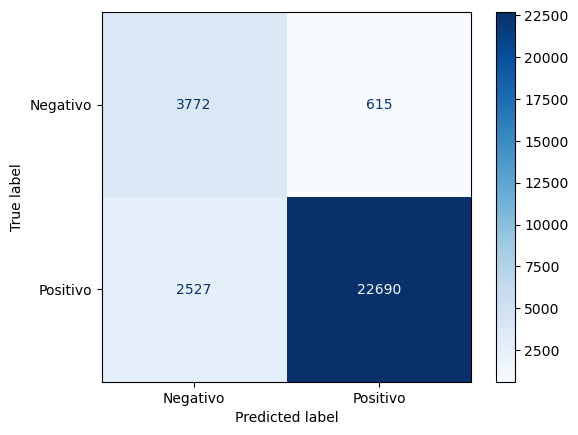

In [38]:
# calcular metricas dos rotulos
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cf = confusion_matrix(df["sentiment(1/0)"], df["sentiment(1/0)GPT"])
ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=["Negativo", "Positivo"]).plot(cmap="Blues")
print(classification_report(df["sentiment(1/0)"], df["sentiment(1/0)GPT"]))

### **5. Rótulos de Confusão**

In [54]:
np.sort(df["confusion(1-7)"].unique())

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ])

#### **5.1 Rotulando dataset completo com Batch API GPT**

In [ ]:
# intervalo, arquivo, resultado = range(0, 5000), "data/confusion/prompts1.jsonl", "data/confusion/resultados1.jsonl"
# intervalo, arquivo, resultado = range(5000, 10000), "data/confusion/prompts2.jsonl", "data/confusion/resultados2.jsonl"
# intervalo, arquivo, resultado = range(10000, 15000), "data/confusion/prompts3.jsonl", "data/confusion/resultados3.jsonl"
# intervalo, arquivo, resultado = range(15000, 20000), "data/confusion/prompts4.jsonl", "data/confusion/resultados4.jsonl"
# intervalo, arquivo, resultado = range(20000, 25000), "data/confusion/prompts5.jsonl", "data/confusion/resultados5.jsonl"
intervalo, arquivo, resultado = range(25000, 29604), "data/confusion/prompts6.jsonl", "data/confusion/resultados6.jsonl"

prompts = []
prompt = 'You are a data scientist who labels texts regarding confusion with one of the options [1.0 , 1.5, 2.0 , 2.5, 3.0 , 3.5, 4.0 , 4.5, 5.0 , 5.5, 6.0 , 6.5, 7.0 ], with 1 being very low confusion and up to 7 being very high confusion. Answer with only one of number option showed and label the following text: '
create_batch(intervalo, arquivo, resultado, prompt, df)

{'id': 'batch_680a45a227c481908fd31ff35475501c',
 'completion_window': '24h',
 'created_at': 1745503650,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-2jfX29qoAC87U4g5rMX1hD',
 'object': 'batch',
 'status': 'validating',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': None,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1745590050,
 'failed_at': None,
 'finalizing_at': None,
 'in_progress_at': None,
 'metadata': {'description': 'gpt label dataset data/confusion/prompts6.jsonl'},
 'output_file_id': None,
 'request_counts': {'completed': 0, 'failed': 0, 'total': 0}}

In [3]:
# verificar situação do lote - outra opção se souber o id do lote
batch = load("data/batch.z")
client.batches.retrieve(batch["id"]).to_dict()

{'id': 'batch_680a45a227c481908fd31ff35475501c',
 'completion_window': '24h',
 'created_at': 1745503650,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-2jfX29qoAC87U4g5rMX1hD',
 'object': 'batch',
 'status': 'completed',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': 1745522303,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1745590050,
 'failed_at': None,
 'finalizing_at': 1745521795,
 'in_progress_at': 1745503651,
 'metadata': {'description': 'gpt label dataset data/confusion/prompts6.jsonl'},
 'output_file_id': 'file-7GKt4vxHDH78Drfe9Rqeqr',
 'request_counts': {'completed': 4604, 'failed': 0, 'total': 4604}}

In [ ]:
# pegar resultado do lote
get_results(batch)

#### **5.2 Tratamento dos resultados**

In [ ]:
r1 = get_labels("data/confusion/resultados1.jsonl")
r2 = get_labels("data/confusion/resultados2.jsonl")
r3 = get_labels("data/confusion/resultados3.jsonl")
r4 = get_labels("data/confusion/resultados4.jsonl")
r5 = get_labels("data/confusion/resultados5.jsonl")
r6 = get_labels("data/confusion/resultados6.jsonl")

gpt_labels = diferenca_percentual(df["confusion(1-7)"], pd.Series(r1 + r2 + r3 + r4 + r5 + r6))
df.insert(10, column="confusion(1/0)GPT", value=gpt_labels.apply(lambda x: 0 if x < 4 else 1))
df.insert(12, column="confusion(1-7)GPT", value=gpt_labels)
df.columns

Index(['text', 'text_pt', 'opinion(1/0)', 'question(1/0)', 'answer(1/0)',
       'sentiment(1/0)', 'sentiment(1/0)GPT', 'sentiment(1-7)',
       'sentiment(1-7)GPT', 'confusion(1/0)', 'confusion(1/0)GPT',
       'confusion(1-7)', 'confusion(1-7)GPT', 'urgency(1/0)', 'urgency(1-7)',
       'coursetype', 'forum_post_id', 'course_display_name', 'forum_uid',
       'created_at', 'post_type', 'anonymous', 'anonymous_to_peers',
       'up_count', 'comment_thread_id', 'reads'],
      dtype='object')

In [41]:
dump(df, "data/df_stanford.z")

['data/df_stanford.z']

              precision    recall  f1-score   support

           0       0.42      0.89      0.57      9654
           1       0.89      0.41      0.56     19950

    accuracy                           0.57     29604
   macro avg       0.65      0.65      0.56     29604
weighted avg       0.73      0.57      0.56     29604



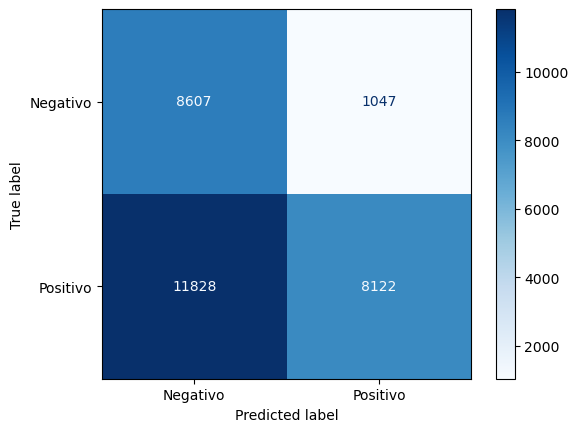

In [40]:
# calcular metricas dos rotulos
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cf = confusion_matrix(df["confusion(1/0)"], df["confusion(1/0)GPT"])
ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=["Negativo", "Positivo"]).plot(cmap="Blues")
print(classification_report(df["confusion(1/0)"], df["confusion(1/0)GPT"]))

### **6. Rótulos de Urgência**

In [19]:
np.unique(df["urgency(1-7)"].unique())

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ])

#### **6.1 Rotulando dataset completo com Batch API GPT**

In [ ]:
# intervalo, arquivo, resultado = range(0, 5000), "data/urgency/prompts1.jsonl", "data/urgency/resultados1.jsonl"
# intervalo, arquivo, resultado = range(5000, 10000), "data/urgency/prompts2.jsonl", "data/urgency/resultados2.jsonl"
# intervalo, arquivo, resultado = range(10000, 15000), "data/urgency/prompts3.jsonl", "data/urgency/resultados3.jsonl"
# intervalo, arquivo, resultado = range(15000, 20000), "data/urgency/prompts4.jsonl", "data/urgency/resultados4.jsonl"
# intervalo, arquivo, resultado = range(20000, 25000), "data/urgency/prompts5.jsonl", "data/urgency/resultados5.jsonl"
intervalo, arquivo, resultado = range(25000, 29604), "data/urgency/prompts6.jsonl", "data/urgency/resultados6.jsonl"

prompts = []
prompt = 'You are a data scientist who labels texts regarding urgency with one of the options [1.0 , 1.5, 2.0 , 2.5, 3.0 , 3.5, 4.0 , 4.5, 5.0 , 5.5, 6.0 , 6.5, 7.0 ], with 1 being few urgency and up to 7 being very urgency. Answer with only one of number option showed and label the following text: '
create_batch(intervalo, arquivo, resultado, prompt, df)

{'id': 'batch_680d499ea4fc8190a3deef1f52d0f11b',
 'completion_window': '24h',
 'created_at': 1745701278,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-XtibtvPXqdDVyKRYRXfSS5',
 'object': 'batch',
 'status': 'validating',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': None,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1745787678,
 'failed_at': None,
 'finalizing_at': None,
 'in_progress_at': None,
 'metadata': {'description': 'gpt label dataset data/urgency/prompts6.jsonl'},
 'output_file_id': None,
 'request_counts': {'completed': 0, 'failed': 0, 'total': 0}}

In [22]:
# verificar situação do lote - outra opção se souber o id do lote
batch = load("data/batch.z")
client.batches.retrieve(batch["id"]).to_dict()

{'id': 'batch_680d499ea4fc8190a3deef1f52d0f11b',
 'completion_window': '24h',
 'created_at': 1745701278,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-XtibtvPXqdDVyKRYRXfSS5',
 'object': 'batch',
 'status': 'completed',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': 1745703261,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1745787678,
 'failed_at': None,
 'finalizing_at': 1745702807,
 'in_progress_at': 1745701281,
 'metadata': {'description': 'gpt label dataset data/urgency/prompts6.jsonl'},
 'output_file_id': 'file-Xc9qmKdosGH9Jit7Lhum64',
 'request_counts': {'completed': 4604, 'failed': 0, 'total': 4604}}

In [ ]:
# pegar resultado do lote
get_results(batch)

#### **6.2 Tratamento dos resultados**

In [ ]:
r1 = get_labels("data/urgency/resultados1.jsonl")
r2 = get_labels("data/urgency/resultados2.jsonl")
r3 = get_labels("data/urgency/resultados3.jsonl")
r4 = get_labels("data/urgency/resultados4.jsonl")
r5 = get_labels("data/urgency/resultados5.jsonl")
r6 = get_labels("data/urgency/resultados6.jsonl")

gpt_labels = diferenca_percentual(df["urgency(1-7)"], pd.Series(r1 + r2 + r3 + r4 + r5 + r6))
df.insert(14, column="urgency(1/0)GPT", value=gpt_labels.apply(lambda x: 0 if x < 4 else 1))
df.insert(16, column="urgency(1-7)GPT", value=gpt_labels)
df.columns

Index(['text', 'text_pt', 'opinion(1/0)', 'question(1/0)', 'answer(1/0)',
       'sentiment(1/0)', 'sentiment(1/0)GPT', 'sentiment(1-7)',
       'sentiment(1-7)GPT', 'confusion(1/0)', 'confusion(1/0)GPT',
       'confusion(1-7)', 'confusion(1-7)GPT', 'urgency(1/0)',
       'urgency(1/0)GPT', 'urgency(1-7)', 'urgency(1-7)GPT', 'coursetype',
       'forum_post_id', 'course_display_name', 'forum_uid', 'created_at',
       'post_type', 'anonymous', 'anonymous_to_peers', 'up_count',
       'comment_thread_id', 'reads'],
      dtype='object')

In [27]:
dump(df, "data/df_stanford.z")

['data/df_stanford.z']

              precision    recall  f1-score   support

           0       0.82      0.93      0.87     23186
           1       0.50      0.25      0.34      6418

    accuracy                           0.78     29604
   macro avg       0.66      0.59      0.60     29604
weighted avg       0.75      0.78      0.76     29604



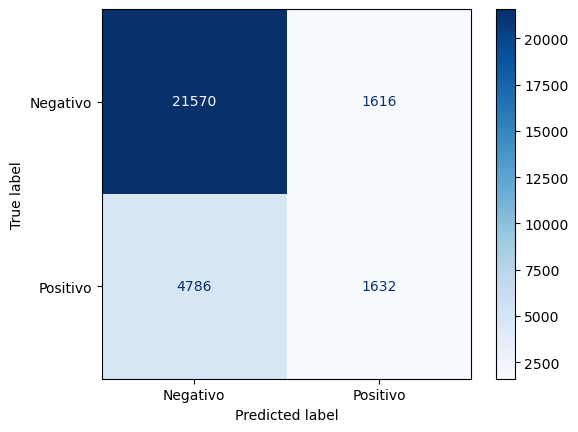

In [26]:
# calcular metricas dos rotulos
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cf = confusion_matrix(df["urgency(1/0)"], df["urgency(1/0)GPT"])
ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=["Negativo", "Positivo"]).plot(cmap="Blues")
print(classification_report(df["urgency(1/0)"], df["urgency(1/0)GPT"]))

### **7. Rótulos de Perguntas**

In [86]:
np.unique(df["question(1/0)"].unique())

array([0, 1], dtype=int64)

#### **7.1 Rotulando dataset completo com Batch API GPT**

In [144]:
# intervalo, arquivo, resultado = range(0, 5000), "data/question/prompts1.jsonl", "data/question/resultados1.jsonl"
# intervalo, arquivo, resultado = range(5000, 10000), "data/question/prompts2.jsonl", "data/question/resultados2.jsonl"
# intervalo, arquivo, resultado = range(10000, 15000), "data/question/prompts3.jsonl", "data/question/resultados3.jsonl"
# intervalo, arquivo, resultado = range(15000, 20000), "data/question/prompts4.jsonl", "data/question/resultados4.jsonl"
# intervalo, arquivo, resultado = range(20000, 25000), "data/question/prompts5.jsonl", "data/question/resultados5.jsonl"
intervalo, arquivo, resultado = range(25000, 29604), "data/question/prompts6.jsonl", "data/question/resultados6.jsonl"

prompts = []
prompt = 'You are a data scientist who labels text indicating whether it is a question or not with the label options [0.0, 1.0], where 1 indicates that it is a question and 0 indicates that it is not. Answer with only one of the options shown and label the following text: '
create_batch(intervalo, arquivo, resultado, prompt, df)

{'id': 'batch_680d86c41b948190a15eb0d9ea74d4a3',
 'completion_window': '24h',
 'created_at': 1745716932,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-8FJxbGpuYt4xAnG3T73WCE',
 'object': 'batch',
 'status': 'validating',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': None,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1745803332,
 'failed_at': None,
 'finalizing_at': None,
 'in_progress_at': None,
 'metadata': {'description': 'gpt label dataset data/question/prompts6.jsonl'},
 'output_file_id': None,
 'request_counts': {'completed': 0, 'failed': 0, 'total': 0}}

In [173]:
# verificar situação do lote - outra opção se souber o id do lote
batch = load("data/batch.z")
client.batches.retrieve(batch["id"]).to_dict()

{'id': 'batch_680d86c41b948190a15eb0d9ea74d4a3',
 'completion_window': '24h',
 'created_at': 1745716932,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-8FJxbGpuYt4xAnG3T73WCE',
 'object': 'batch',
 'status': 'completed',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': 1745718791,
 'error_file_id': 'file-TBa3ijH8gES6EXP6FRSSPT',
 'errors': None,
 'expired_at': None,
 'expires_at': 1745803332,
 'failed_at': None,
 'finalizing_at': 1745718292,
 'in_progress_at': 1745716934,
 'metadata': {'description': 'gpt label dataset data/question/prompts6.jsonl'},
 'output_file_id': 'file-TKjJAPdkX8m1oiCN6XYvcx',
 'request_counts': {'completed': 4604, 'failed': 0, 'total': 4604}}

In [174]:
# pegar resultado do lote
get_results(batch)

#### **7.2 Tratamento dos resultados**

In [10]:
r1 = get_binary_labels("data/question/resultados1.jsonl")
r2 = get_binary_labels("data/question/resultados2.jsonl")
r3 = get_binary_labels("data/question/resultados3.jsonl")
r4 = get_binary_labels("data/question/resultados4.jsonl")
r5 = get_binary_labels("data/question/resultados5.jsonl")
r6 = get_binary_labels("data/question/resultados6.jsonl")

df.insert(4, column="question(1/0)GPT", value=pd.Series(r1 + r2 + r3 + r4 + r5 + r6))
df.columns

Index(['text', 'text_pt', 'opinion(1/0)', 'question(1/0)', 'question(1/0)GPT',
       'answer(1/0)', 'sentiment(1/0)', 'sentiment(1/0)GPT', 'sentiment(1-7)',
       'sentiment(1-7)GPT', 'confusion(1/0)', 'confusion(1/0)GPT',
       'confusion(1-7)', 'confusion(1-7)GPT', 'urgency(1/0)',
       'urgency(1/0)GPT', 'urgency(1-7)', 'urgency(1-7)GPT', 'coursetype',
       'forum_post_id', 'course_display_name', 'forum_uid', 'created_at',
       'post_type', 'anonymous', 'anonymous_to_peers', 'up_count',
       'comment_thread_id', 'reads'],
      dtype='object')

In [12]:
dump(df, "data/df_stanford.z")

['data/df_stanford.z']

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     23645
           1       0.77      0.89      0.83      5959

    accuracy                           0.93     29604
   macro avg       0.87      0.91      0.89     29604
weighted avg       0.93      0.93      0.93     29604



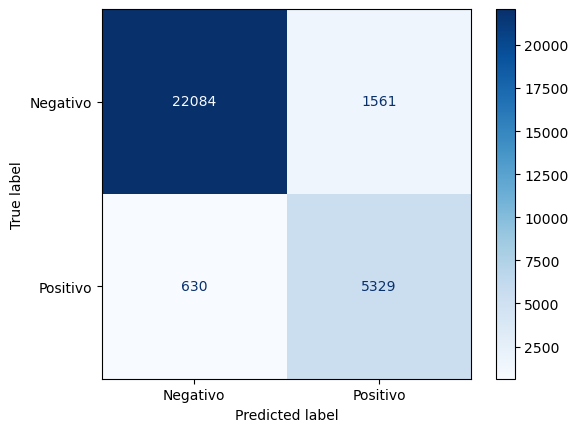

In [11]:
# calcular metricas dos rotulos
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cf = confusion_matrix(df["question(1/0)"], df["question(1/0)GPT"])
ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=["Negativo", "Positivo"]).plot(cmap="Blues")
print(classification_report(df["question(1/0)"], df["question(1/0)GPT"]))

### **8. Rótulos de Respostas**

In [5]:
np.unique(df["answer(1/0)"].unique())

array([0, 1], dtype=int64)

#### **8.1 Rotulando dataset completo com Batch API GPT**

In [5]:
# intervalo, arquivo, resultado = range(0, 5000), "data/answer/prompts1.jsonl", "data/answer/resultados1.jsonl"
# intervalo, arquivo, resultado = range(5000, 10000), "data/answer/prompts2.jsonl", "data/answer/resultados2.jsonl"
# intervalo, arquivo, resultado = range(10000, 15000), "data/answer/prompts3.jsonl", "data/answer/resultados3.jsonl"
# intervalo, arquivo, resultado = range(15000, 20000), "data/answer/prompts4.jsonl", "data/answer/resultados4.jsonl"
# intervalo, arquivo, resultado = range(20000, 25000), "data/answer/prompts5.jsonl", "data/answer/resultados5.jsonl"
intervalo, arquivo, resultado = range(25000, 29604), "data/answer/prompts6.jsonl", "data/answer/resultados6.jsonl"

prompts = []
prompt = 'You are a data scientist labeling text indicating whether the following message is an answer to a possible question that was previously asked or not. With the label options [0,0,1,0], where 1 indicates that the message is an answer and 0 indicates that it is not. Respond with only one of the options shown and label the following text: '
create_batch(intervalo, arquivo, resultado, prompt, df)

{'id': 'batch_681619a2b3908190a29fd0adcac894e6',
 'completion_window': '24h',
 'created_at': 1746278818,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-SYJt7BSjqa8NDMpXQVoCNp',
 'object': 'batch',
 'status': 'validating',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': None,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1746365218,
 'failed_at': None,
 'finalizing_at': None,
 'in_progress_at': None,
 'metadata': {'description': 'gpt label dataset data/answer/prompts6.jsonl'},
 'output_file_id': None,
 'request_counts': {'completed': 0, 'failed': 0, 'total': 0}}

In [4]:
# verificar situação do lote - outra opção se souber o id do lote
batch = load("data/batch.z")
print(f"Criado em: {pd.to_datetime(batch["created_at"], unit="s") - pd.to_timedelta(3, unit='h')}:", end=" ")
print(client.batches.retrieve(batch["id"]).to_dict()["status"])
display(client.batches.retrieve(batch["id"]).to_dict())

Criado em: 2025-05-03 10:26:58: completed


{'id': 'batch_681619a2b3908190a29fd0adcac894e6',
 'completion_window': '24h',
 'created_at': 1746278818,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-SYJt7BSjqa8NDMpXQVoCNp',
 'object': 'batch',
 'status': 'completed',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': 1746283148,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1746365218,
 'failed_at': None,
 'finalizing_at': 1746282607,
 'in_progress_at': 1746278820,
 'metadata': {'description': 'gpt label dataset data/answer/prompts6.jsonl'},
 'output_file_id': 'file-AVCx6L5u3byukaLuspop1i',
 'request_counts': {'completed': 4604, 'failed': 0, 'total': 4604}}

In [5]:
# pegar resultado do lote
get_results(batch)

#### **8.2 Tratamento dos resultados**

In [7]:
r1 = get_binary_labels("data/answer/resultados1.jsonl")
r2 = get_binary_labels("data/answer/resultados2.jsonl")
r3 = get_binary_labels("data/answer/resultados3.jsonl")
r4 = get_binary_labels("data/answer/resultados4.jsonl")
r5 = get_binary_labels("data/answer/resultados5.jsonl")
r6 = get_binary_labels("data/answer/resultados6.jsonl")

df.insert(6, column="answer(1/0)GPT", value=pd.Series(r1 + r2 + r3 + r4 + r5 + r6))
df.columns

Index(['text', 'text_pt', 'opinion(1/0)', 'question(1/0)', 'question(1/0)GPT',
       'answer(1/0)', 'answer(1/0)GPT', 'sentiment(1/0)', 'sentiment(1/0)GPT',
       'sentiment(1-7)', 'sentiment(1-7)GPT', 'confusion(1/0)',
       'confusion(1/0)GPT', 'confusion(1-7)', 'confusion(1-7)GPT',
       'urgency(1/0)', 'urgency(1/0)GPT', 'urgency(1-7)', 'urgency(1-7)GPT',
       'coursetype', 'forum_post_id', 'course_display_name', 'forum_uid',
       'created_at', 'post_type', 'anonymous', 'anonymous_to_peers',
       'up_count', 'comment_thread_id', 'reads'],
      dtype='object')

In [ ]:
dump(df, "data/df_stanford.z")

              precision    recall  f1-score   support

           0       0.84      0.91      0.87     23549
           1       0.48      0.34      0.40      6055

    accuracy                           0.79     29604
   macro avg       0.66      0.62      0.63     29604
weighted avg       0.77      0.79      0.78     29604



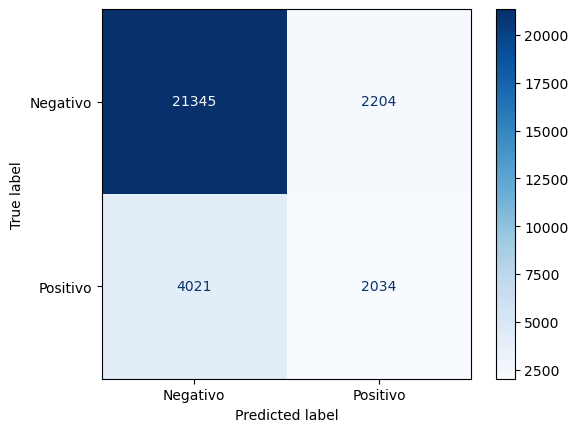

In [8]:
# calcular metricas dos rotulos
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cf = confusion_matrix(df["answer(1/0)"], df["answer(1/0)GPT"])
ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=["Negativo", "Positivo"]).plot(cmap="Blues")
print(classification_report(df["answer(1/0)"], df["answer(1/0)GPT"]))

### **9. Rótulos de Opiniões**

In [10]:
np.unique(df["opinion(1/0)"].unique())

array([0, 1], dtype=int64)

#### **9.1 Rotulando dataset completo com Batch API GPT**

In [11]:
intervalo, arquivo, resultado = range(0, 5000), "data/opinion/prompts1.jsonl", "data/opinion/resultados1.jsonl"
# intervalo, arquivo, resultado = range(5000, 10000), "data/opinion/prompts2.jsonl", "data/opinion/resultados2.jsonl"
# intervalo, arquivo, resultado = range(10000, 15000), "data/opinion/prompts3.jsonl", "data/opinion/resultados3.jsonl"
# intervalo, arquivo, resultado = range(15000, 20000), "data/opinion/prompts4.jsonl", "data/opinion/resultados4.jsonl"
# intervalo, arquivo, resultado = range(20000, 25000), "data/opinion/prompts5.jsonl", "data/opinion/resultados5.jsonl"
# intervalo, arquivo, resultado = range(25000, 29604), "data/opinion/prompts6.jsonl", "data/opinion/resultados6.jsonl"

prompts = []
prompt = 'You are a data scientist and you are labeling text and indicating whether the following message is an expression of a personal opinion or not. With the label options [0,0,1,0], where 1 indicates that the message is a personal opinion and 0 indicates that it is not. Respond with only one of the options shown and label the following text: '
create_batch(intervalo, arquivo, resultado, prompt, df)

{'id': 'batch_6816325205948190945c61e432ebaebf',
 'completion_window': '24h',
 'created_at': 1746285138,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-9rf8xuD9sdXiVByNfzbJt5',
 'object': 'batch',
 'status': 'validating',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': None,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1746371538,
 'failed_at': None,
 'finalizing_at': None,
 'in_progress_at': None,
 'metadata': {'description': 'gpt label dataset data/opinion/prompts1.jsonl'},
 'output_file_id': None,
 'request_counts': {'completed': 0, 'failed': 0, 'total': 0}}

In [13]:
# verificar situação do lote - outra opção se souber o id do lote
batch = load("data/batch.z")
print(f"Criado em: {pd.to_datetime(batch["created_at"], unit="s") - pd.to_timedelta(3, unit='h')}:", end=" ")
print(client.batches.retrieve(batch["id"]).to_dict()["status"])
display(client.batches.retrieve(batch["id"]).to_dict())

Criado em: 2025-05-03 12:12:18: in_progress


{'id': 'batch_6816325205948190945c61e432ebaebf',
 'completion_window': '24h',
 'created_at': 1746285138,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-9rf8xuD9sdXiVByNfzbJt5',
 'object': 'batch',
 'status': 'in_progress',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': None,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1746371538,
 'failed_at': None,
 'finalizing_at': None,
 'in_progress_at': 1746285139,
 'metadata': {'description': 'gpt label dataset data/opinion/prompts1.jsonl'},
 'output_file_id': None,
 'request_counts': {'completed': 0, 'failed': 0, 'total': 5000}}

In [ ]:
# pegar resultado do lote
get_results(batch)